# Visualization Tool
Extremely flexible tool to visualize and debug the data pipeline (data loading, processing, and augmentation ) suitable for machine learning experiments.  The package comes with a rich collection of visualizers and workflows. 


## VisProbe Op
This op can be placed between different steps at the pipeline .

Each VisProbe op can have an optional name which will appear in every image and file created by the visualizer.

This op requires the following inputs in each call :
1. give the input keys that define a "namespace" which included your input ( e.g keys={"image": "data.img", "seg": "data.seg"}) 
2. visualizer - instance of a class that inherits from VisualizerBase ( SaveVisual - to save to nifti file , Imaging2dVisualizer - to save multiple 2d images in one file)
3. output_path - path to save the images
4. VisFlag - indicates what to do in the current step  

    A.  VisFlag.VISUALIZE_CURRENT - visualize only current step 

    B.  VisFlag.COLLECT - save the image in stack and show later

    C.  VisFlag.VISUALIZE_COLLECTED - visualize current step and all collected before it

    D.  VisFlag.CLEAR - clear the stack of collected images

5. name of the image to be visualized
The default behaviour is to save to file the visualization, 
Alternatively you can change to show it online by using original_flag | VisFlag.ONLINE



In [1]:
from functools import partial
import os
import torch

from fuse.data import PipelineDefault, OpToTensor, OpRepeat
from fuseimg.data.ops.aug.geometry import OpAugAffine2D
from fuseimg.data.ops.image_loader import OpLoadImage , OpDownloadImage
from fuse.data.ops.ops_visprobe import VisFlag, VisProbe 
from fuse.data.pipelines.pipeline_default import PipelineDefault
from fuseimg.utils.visualization.visualizer2D import Imaging2dVisualizer
from fuseimg.utils.visualization.save_to_format import SaveToFormat

from fuseimg.data.ops.shape_ops import OpSelectSlice

from fuse.data import PipelineDefault, OpSampleAndRepeat, OpToTensor, OpRepeat

from tempfile import gettempdir
from fuseimg.datasets.kits21 import KITS21
from pycocotools.coco import COCO
from fuse.utils.ndict import NDict

def create_sample_1(views=2):
    data_dir = os.path.join(os.getcwd(), "kits21_data")
    KITS21.download(data_dir, cases=[100,200])

    sample = NDict()
    if views >= 1:
        sample['data.img_filename'] = os.path.join(
            data_dir, 'case_00100/imaging.nii.gz') 
        sample['data.seg_filename'] = os.path.join(
            data_dir, 'case_00100/aggregated_MAJ_seg.nii.gz')
    
    return sample , data_dir

## Basic example - using SaveVisual

in each step we call VisProbe with same flag VisFlag.VISUALIZE_CURRENT.

images and segmentation will be saved to the output folder ,
including the given pipe and operation name and the index location in the pipeline

In [6]:
sample , data_dir = create_sample_1(views=1)  
os.mkdir(os.path.join(gettempdir(),"vis_data"))      
visual = SaveToFormat()
VProbe = partial(VisProbe, 
                    keys={"image": "data.img", "seg": "data.seg"},
                    visualizer = visual, output_path=os.path.join(gettempdir(),"vis_data"))
repeat_for = [dict(key="data.img"), dict(key="data.seg")]
pipeline = PipelineDefault('test_pipeline', [
    (OpLoadImage(data_dir), dict(key_in = 'data.img_filename', key_out='data.img', format="nib")),
    (OpLoadImage(data_dir), dict(key_in = 'data.seg_filename', key_out='data.seg', format="nib")),
    (OpRepeat(OpToTensor(), kwargs_per_step_to_add=repeat_for), dict(dtype=torch.float32)),
    (VProbe( VisFlag.VISUALIZE_CURRENT , name = "first"), {}),
    (OpSampleAndRepeat(OpAugAffine2D (), kwargs_per_step_to_add=repeat_for), dict(
        rotate=30.0
    )),
    (VProbe( VisFlag.VISUALIZE_CURRENT, name = "last"), {}),
    
])

sample = pipeline(sample)

100%|██████████| 2/2 [00:00<00:00, 1197.69it/s]


imaging.nii.gz number 100 was found
aggregated_MAJ_seg.nii.gz number 100 was found
imaging.nii.gz number 200 was found
aggregated_MAJ_seg.nii.gz number 200 was found


we can see the following files were created in the running dir

those files can be opened either by itksnap or NeuroViewer VScode extension

In [7]:
print([file for file in os.listdir(os.path.join(gettempdir(),"vis_data")) if "nii.gz" in file])
os.rmdir(os.path.join(gettempdir(),"vis_data"))

['img_last_test_pipeline.5.nii.gz', 'seg_first_test_pipeline.3.nii.gz', 'img_first_test_pipeline.3.nii.gz', 'seg_last_test_pipeline.5.nii.gz']


## multi view example - using Imaging2dVisualizer
in each step we call VisProbe with same flag VisFlag.COLLECT and in the end we call with VisFlag.SHOW_COLLECTED

because we are using ONLINE mode images will be displayed in console.

The follwing example donwloads kits21 image and segmentation and visualize it's rotation and in a specific slice ( so we can use 2d visualizer)


100%|██████████| 2/2 [00:00<00:00, 810.18it/s]


imaging.nii.gz number 100 was found
aggregated_MAJ_seg.nii.gz number 100 was found
imaging.nii.gz number 200 was found
aggregated_MAJ_seg.nii.gz number 200 was found


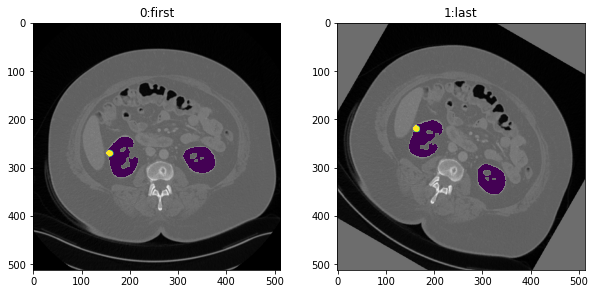

In [2]:
%matplotlib inline

sample , data_dir = create_sample_1(views=1)
visual = Imaging2dVisualizer(cmap = 'gray')
VProbe = partial(VisProbe, 
                    keys={"image": "data.image", "seg": "data.seg"},
                    visualizer = visual)
repeat_for = [dict(key="data.image"), dict(key="data.seg")]
slice_idx = 190
pipeline = PipelineDefault('test_pipeline', [
    (OpLoadImage(data_dir), dict(key_in = 'data.img_filename', key_out='data.image', format="nib")),
    (OpLoadImage(data_dir), dict(key_in = 'data.seg_filename', key_out='data.seg', format="nib")),
    (OpSelectSlice(), dict(key="data.image", slice_idx = slice_idx)),
    (OpSelectSlice(), dict(key="data.seg", slice_idx = slice_idx)),
    (OpRepeat(OpToTensor(), kwargs_per_step_to_add=repeat_for), dict(dtype=torch.float32)),
    (VProbe( VisFlag.COLLECT , name = "first"), {}),
    (OpSampleAndRepeat(OpAugAffine2D (), kwargs_per_step_to_add=repeat_for), dict(
        rotate=30.0
    )),
    (VProbe( flags=VisFlag.VISUALIZE_COLLECTED | VisFlag.ONLINE , name = "last" ), {}),
    
])

sample = pipeline(sample)

## Support for other segmentation types - contour and bounding box
Other segmentation types such as contours and bounding box can also be supported, 
They require special operations to work with them ( e.g rotating , clipping ) while conserving thier type.
These ops are not yet implemented so we show only the the image after loading.

The following example loads some COCO dataset images and segmentations and visualizes them

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
328 {'id': 328, 'folder': None, 'file_name': 'COCO_val2014_000000000328.jpg', 'path': None, 'width': 640, 'height': 491, 'depth': None}


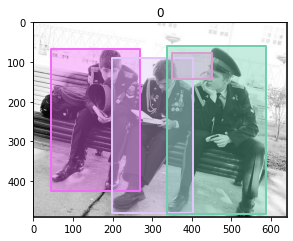

730 {'id': 730, 'folder': None, 'file_name': 'COCO_val2014_000000000730.jpg', 'path': None, 'width': 640, 'height': 428, 'depth': None}


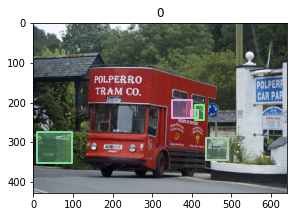

810 {'id': 810, 'folder': None, 'file_name': 'COCO_val2014_000000000810.jpg', 'path': None, 'width': 640, 'height': 480, 'depth': None}


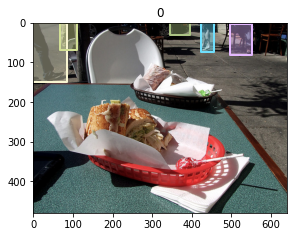

923 {'id': 923, 'folder': None, 'file_name': 'COCO_val2014_000000000923.jpg', 'path': None, 'width': 640, 'height': 485, 'depth': None}


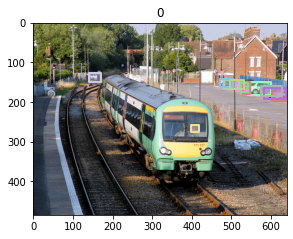

In [3]:
%matplotlib inline

visual = Imaging2dVisualizer(cmap = 'gray' )
dir_path = os.getcwd()
annotation_path =os.path.join(dir_path,'tests/inputs/detection/example_coco_new.json')
cocoGt=COCO(annotation_path)
#initialize COCO detections api
resFile=os.path.join(dir_path,'tests/inputs/detection/instances_val2014_fakesegm100_results.json')
coco=cocoGt.loadRes(resFile)
catNms=['person','car']
catIds = coco.getCatIds(catNms)
imgIds = coco.getImgIds(catIds=catIds )
VProbe = partial(VisProbe, 
keys=  {"image":"data.img" , "bboxes":"data.bbox"}, 
visualizer = visual)
pipeline = PipelineDefault('test_pipeline', [
        (OpDownloadImage(), dict(key_in ='data.img_filename', key_out='data.img')),
        (VProbe( flags=VisFlag.VISUALIZE_CURRENT | VisFlag.ONLINE ), {}),
    
    ])
for img_id in imgIds:
    for img in coco.loadImgs(ids = [img_id]):
        print(img_id,img)
        sample_dict = NDict()
        sample_dict['data.img_filename'] = "http://images.cocodataset.org/val2014/"+img['file_name'] 
        target_annIds = cocoGt.getAnnIds(imgIds=img_id, catIds=[str(id) for id in catIds], iscrowd=None)
        segmentations = []
        for seg in cocoGt.loadAnns(target_annIds) :
            segmentations.append(seg["bbox"])
        sample_dict["data.bbox"] = segmentations
        sample_dict = pipeline(sample_dict)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
328 {'id': 328, 'folder': None, 'file_name': 'COCO_val2014_000000000328.jpg', 'path': None, 'width': 640, 'height': 491, 'depth': None}


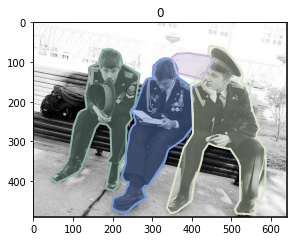

730 {'id': 730, 'folder': None, 'file_name': 'COCO_val2014_000000000730.jpg', 'path': None, 'width': 640, 'height': 428, 'depth': None}


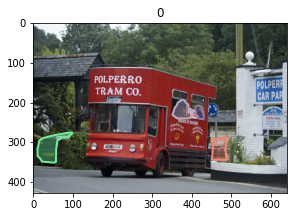

810 {'id': 810, 'folder': None, 'file_name': 'COCO_val2014_000000000810.jpg', 'path': None, 'width': 640, 'height': 480, 'depth': None}


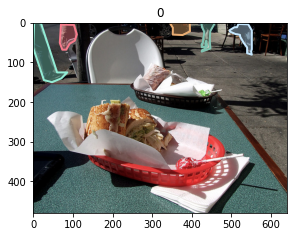

923 {'id': 923, 'folder': None, 'file_name': 'COCO_val2014_000000000923.jpg', 'path': None, 'width': 640, 'height': 485, 'depth': None}


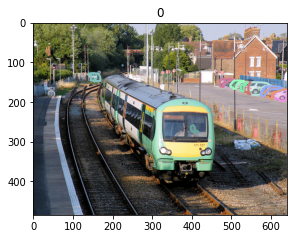

In [4]:
%matplotlib inline

visual = Imaging2dVisualizer(cmap = 'gray' )
dir_path = os.getcwd()
annotation_path =os.path.join(dir_path,'tests/inputs/detection/example_coco_new.json')
cocoGt=COCO(annotation_path)
#initialize COCO detections api
resFile=os.path.join(dir_path,'tests/inputs/detection/instances_val2014_fakesegm100_results.json')
coco=cocoGt.loadRes(resFile)
catNms=['person','car']
catIds = coco.getCatIds(catNms)
imgIds = coco.getImgIds(catIds=catIds )
VProbe = partial(VisProbe, 
keys=  {"image":"data.img" , "contours":"data.ctr"}, 
visualizer = visual)
pipeline = PipelineDefault('test_pipeline', [
        (OpDownloadImage(), dict(key_in ='data.img_filename', key_out='data.img')),
        (VProbe( flags=VisFlag.VISUALIZE_CURRENT | VisFlag.ONLINE ), {}),
    
    ])
for img_id in imgIds:
    for img in coco.loadImgs(ids = [img_id]):
        print(img_id,img)
        sample_dict = NDict()
        sample_dict['data.img_filename'] = "http://images.cocodataset.org/val2014/"+img['file_name'] 
        target_annIds = cocoGt.getAnnIds(imgIds=img_id, catIds=[str(id) for id in catIds], iscrowd=None)
        segmentations = []
        for seg in cocoGt.loadAnns(target_annIds) :
            segmentations.append(seg["segmentation"])
        sample_dict["data.ctr"] = segmentations
        sample_dict = pipeline(sample_dict)